In [15]:
import pandas as pd
import os
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.manifold import TSNE
import umap
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [3]:
# Get the list of CSV files in the data folder
data_folder = 'data//cleaned_coffee_data'
csv_files = [file for file in os.listdir(data_folder) if file.endswith('.csv')]

# Dictionary to store the dataframes
dataframes = {}

# Load each CSV file into a dataframe
for file in csv_files:
    # Create a dataframe name from the file name (removing .csv extension)
    df_name = file.replace('.csv', '')
    
    # Load the dataframe
    file_path = os.path.join(data_folder, file)
    dataframes[df_name] = pd.read_csv(file_path)

# List all dataframe names
print("List of all dataframe names:")
for i, name in enumerate(dataframes.keys(), 1):
    print(f"{i}. {name}")

List of all dataframe names:
1. coffee_2018_cleaned
2. coffee_2023_cleaned
3. coffee_combined_2018_2023


In [7]:
coffee_combined_2018_2023 = dataframes['coffee_combined_2018_2023']
coffee_combined_2018_2023.columns = [col.replace('.', '_') for col in coffee_combined_2018_2023.columns]

display(coffee_combined_2018_2023.head())
display(coffee_combined_2018_2023.info())


,Species,Country_of_Origin,Harvest_Year,Color,Processing_Method,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Clean_Cup,Sweetness,Cupper_Points,Total_Cup_Points
0,Arabica,Ethiopia,2014,Green,Washed / Wet,8.67,8.83,8.67,8.75,8.50,8.42,10.0,10.0,10.0,8.75,90.58
1,Arabica,Ethiopia,2014,Green,Washed / Wet,8.75,8.67,8.50,8.58,8.42,8.42,10.0,10.0,10.0,8.58,89.92
2,Arabica,Guatemala,Unknown,Unknown,Unknown,8.42,8.50,8.42,8.42,8.33,8.42,10.0,10.0,10.0,9.25,89.75
3,Arabica,Ethiopia,2014,Green,Natural / Dry,8.17,8.58,8.42,8.42,8.50,8.25,10.0,10.0,10.0,8.67,89.00
4,Arabica,Ethiopia,2014,Green,Washed / Wet,8.25,8.50,8.25,8.50,8.42,8.33,10.0,10.0,10.0,8.58,88.83


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1517 entries, 0 to 1516
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Species            1517 non-null   object 
 1   Country_of_Origin  1517 non-null   object 
 2   Harvest_Year       1517 non-null   object 
 3   Color              1517 non-null   object 
 4   Processing_Method  1517 non-null   object 
 5   Aroma              1517 non-null   float64
 6   Flavor             1517 non-null   float64
 7   Aftertaste         1517 non-null   float64
 8   Acidity            1517 non-null   float64
 9   Body               1517 non-null   float64
 10  Balance            1517 non-null   float64
 11  Uniformity         1517 non-null   float64
 12  Clean_Cup          1517 non-null   float64
 13  Sweetness          1517 non-null   float64
 14  Cupper_Points      1517 non-null   float64
 15  Total_Cup_Points   1517 non-null   float64
dtypes: float64(11), object(5

None

In [8]:
# Precheck for standardization
# List of string columns
string_cols = [
    "Species",
    "Country_of_Origin",
    "Harvest_Year",
    "Color",
    "Processing_Method"
]

# Loop through and print unique values
for col in string_cols:
    print(f"\n--- {col} ---")
    print(coffee_combined_2018_2023[col].unique())
    print(f"Total unique values: {coffee_combined_2018_2023[col].nunique()}")



--- Species ---
['Arabica']
Total unique values: 1

--- Country_of_Origin ---
['Ethiopia' 'Guatemala' 'Brazil' 'Peru' 'United States'
 'United States (Hawaii)' 'Indonesia' 'China' 'Costa Rica' 'Mexico'
 'Uganda' 'Honduras' 'Taiwan' 'Nicaragua' 'Tanzania, United Republic Of'
 'Kenya' 'Thailand' 'Colombia' 'Panama' 'Papua New Guinea' 'El Salvador'
 'Japan' 'Ecuador' 'United States (Puerto Rico)' 'Haiti' 'Burundi'
 'Vietnam' 'Philippines' 'Rwanda' 'Malawi' 'Laos' 'Zambia' 'Myanmar'
 'Mauritius' 'Cote d?Ivoire' 'India' 'Madagascar']
Total unique values: 37

--- Harvest_Year ---
['2014' 'Unknown' '2013' '2012' '2010' '2009-2010' '2015' '2011' '2016'
 '2015-2016' '2009' '2017' '2010-2011' '2013-2014' '2017-2018' '2014-2015'
 '2011-2012' '2016-2017' '2018' '2008-2009' '2021-2022' '2022' '2022-2023'
 '2021' '2018-2019' '2023']
Total unique values: 26

--- Color ---
['Green' 'Unknown' 'Bluish-Green' 'Blue-Green' 'green' 'blue-green'
 'yellowish' 'yellow-green' 'yellow green' 'greenish' 'browni

In [14]:
# Fixes
# Country_of_Origin 
coffee_combined_2018_2023["Country_of_Origin"] = coffee_combined_2018_2023["Country_of_Origin"].replace("Cote d?Ivoire", "Ivory Coast")
coffee_combined_2018_2023["Country_of_Origin"] = coffee_combined_2018_2023["Country_of_Origin"].replace("Tanzania, United Republic Of", "Tanzania")

# Color
# Convert everything to lowercase and strip spaces
coffee_combined_2018_2023["Color"] = coffee_combined_2018_2023["Color"].str.lower().str.strip()

# Define a mapping
color_map = {
    "green": "green",
    "bluish-green": "blue-green",
    "blue-green": "blue-green",
    "blue green": "blue-green",
    "bluish green": "blue-green",
    "yellowish": "yellow",
    "yellow-green": "yellow-green",
    "yellow green": "yellow-green",
    "yello-green": "yellow-green",
    "yellow- green": "yellow-green",
    "greenish": "green",
    "brownish": "brown",
    "browish-green": "brown-green",
    "pale yellow": "yellow"
}

# Apply mapping
coffee_combined_2018_2023["Color"] = coffee_combined_2018_2023["Color"].replace(color_map)

# Loop through and print unique values
for col in string_cols:
    print(f"\n--- {col} ---")
    print(coffee_combined_2018_2023[col].unique())
    print(f"Total unique values: {coffee_combined_2018_2023[col].nunique()}")


--- Species ---
['Arabica']
Total unique values: 1

--- Country_of_Origin ---
['Ethiopia' 'Guatemala' 'Brazil' 'Peru' 'United States'
 'United States (Hawaii)' 'Indonesia' 'China' 'Costa Rica' 'Mexico'
 'Uganda' 'Honduras' 'Taiwan' 'Nicaragua' 'Tanzania' 'Kenya' 'Thailand'
 'Colombia' 'Panama' 'Papua New Guinea' 'El Salvador' 'Japan' 'Ecuador'
 'United States (Puerto Rico)' 'Haiti' 'Burundi' 'Vietnam' 'Philippines'
 'Rwanda' 'Malawi' 'Laos' 'Zambia' 'Myanmar' 'Mauritius' 'Ivory Coast'
 'India' 'Madagascar']
Total unique values: 37

--- Harvest_Year ---
['2014' 'Unknown' '2013' '2012' '2010' '2009-2010' '2015' '2011' '2016'
 '2015-2016' '2009' '2017' '2010-2011' '2013-2014' '2017-2018' '2014-2015'
 '2011-2012' '2016-2017' '2018' '2008-2009' '2021-2022' '2022' '2022-2023'
 '2021' '2018-2019' '2023']
Total unique values: 26

--- Color ---
['green' 'unknown' 'blue-green' 'yellow' 'yellow-green' 'brown'
 'brown-green']
Total unique values: 7

--- Processing_Method ---
['Washed / Wet' 'Unkn

Quality_Category
0    77.795529
2    82.197303
1    84.673642
Name: Total_Cup_Points, dtype: float64


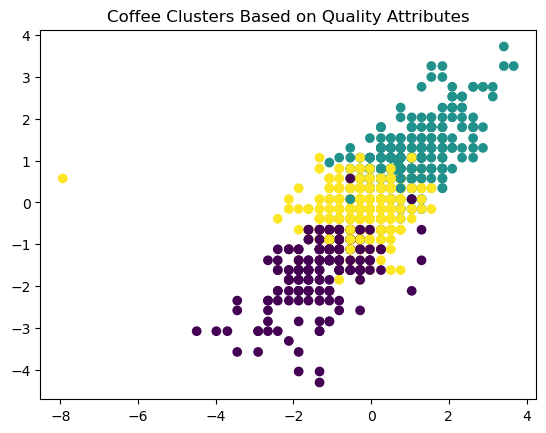

In [22]:
# Automatic Tagging

df = coffee_combined_2018_2023.copy()

# Select the sensory numeric features
features = [
    "Aroma", "Flavor", "Aftertaste", "Acidity", "Body", 
    "Balance", "Uniformity", "Clean_Cup", "Sweetness", 
    "Cupper_Points", "Total_Cup_Points"
]

X = df[features].dropna()

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
df["Quality_Category"] = kmeans.fit_predict(X_scaled)

# Optional: label the clusters based on mean scores
#cluster_means = df.groupby("Quality_Category")[features].mean()
#print(cluster_means)

cluster_order = (
    df.groupby("Quality_Category")["Total_Cup_Points"]
    .mean()
    .sort_values()
)
print(cluster_order)

# Visualize
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=df["Quality_Category"], cmap="viridis")
plt.title("Coffee Clusters Based on Quality Attributes")
plt.show()

In [28]:
# Apply quality labels to clusters
label_map = {0: "Low Quality", 2: "Medium Quality", 1: "High Quality"}
df["Quality_Label"] = df["Quality_Category"].map(label_map)

df['Quality_Label'].value_counts()

Quality_Label
Medium Quality    823
High Quality      486
Low Quality       208
Name: count, dtype: int64

In [30]:
# Define sensory columns and their tag names
sensory_tags = {
    'Sweetness': 'Sweet',
    'Acidity': 'Sour',
    'Body': 'Full-bodied',
    'Aftertaste': 'Lingering'
}

# Calculate 75th and 25th percentile cutoffs
cutoffs_high = df[list(sensory_tags.keys())].quantile(0.75)
cutoffs_low = df[['Acidity']].quantile(0.25)  # only for Smooth

# Function to assign readable tags
def categorize_coffee(row):
    categories = []
    
    # Upper quartile sensory tags
    for col, tag in sensory_tags.items():
        if row[col] >= cutoffs_high[col]:
            categories.append(tag)
    
    # Low-acidity → Smooth
    if row['Acidity'] <= cutoffs_low['Acidity']:
        categories.append('Smooth')
    
    # Aroma tag (high = Aromatic)
    if row['Aroma'] >= df['Aroma'].quantile(0.75):
        categories.append('Aromatic')
    
    # Aftertaste tag (high = Complex)
    if row['Aftertaste'] >= df['Aftertaste'].quantile(0.75):
        categories.append('Complex')
    
    # Quality Tier from K-Means clustering
    categories.append(row['Quality_Label'])
    
    return categories

# Apply to dataframe
df['Taste_Categories'] = df.apply(categorize_coffee, axis=1)

# Check distribution
print("Details of Taste_Categories:\n")
print(df['Taste_Categories'].value_counts())


Details of Taste_Categories:

Taste_Categories
[Sweet, Medium Quality]                                                   359
[Sweet, Smooth, Medium Quality]                                           170
[Sweet, Sour, Full-bodied, Lingering, Aromatic, Complex, High Quality]    150
[Sweet, Smooth, Low Quality]                                              146
[Sweet, Aromatic, Medium Quality]                                          70
                                                                         ... 
[Full-bodied, Smooth, Aromatic, Medium Quality]                             1
[Full-bodied, Lingering, Complex, High Quality]                             1
[Sweet, Full-bodied, Smooth, Aromatic, Medium Quality]                      1
[Sweet, Full-bodied, Smooth, High Quality]                                  1
[Lingering, Smooth, Aromatic, Complex, Low Quality]                         1
Name: count, Length: 73, dtype: int64


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1517 entries, 0 to 1516
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Species             1517 non-null   object 
 1   Country_of_Origin   1517 non-null   object 
 2   Harvest_Year        1517 non-null   object 
 3   Color               1517 non-null   object 
 4   Processing_Method   1517 non-null   object 
 5   Aroma               1517 non-null   float64
 6   Flavor              1517 non-null   float64
 7   Aftertaste          1517 non-null   float64
 8   Acidity             1517 non-null   float64
 9   Body                1517 non-null   float64
 10  Balance             1517 non-null   float64
 11  Uniformity          1517 non-null   float64
 12  Clean_Cup           1517 non-null   float64
 13  Sweetness           1517 non-null   float64
 14  Cupper_Points       1517 non-null   float64
 15  Total_Cup_Points    1517 non-null   float64
 16  Color_

In [33]:
# Write to CSV files - one CSV per quality level

# --- 0. Create output directory ---
output_dir = os.path.join("data", "coffees_categorized")
os.makedirs(output_dir, exist_ok=True)  # creates the folder if it doesn't exist

# --- 1. Expand Taste_Categories into individual boolean columns ---
# Create dummy columns for each tag
tag_dummies = df['Taste_Categories'].explode().str.get_dummies().groupby(level=0).max()

# Prefix column names to avoid conflicts
tag_dummies = tag_dummies.add_prefix('Category_')

# Merge back into the main dataframe
df = pd.concat([df, tag_dummies], axis=1)

# --- 2. Split by quality level ---
low_df = df[df['Taste_Categories'].apply(lambda x: 'Low Quality' in x)]
med_df = df[df['Taste_Categories'].apply(lambda x: 'Medium Quality' in x)]
high_df = df[df['Taste_Categories'].apply(lambda x: 'High Quality' in x)]

# --- 3. Save each subset to CSV inside the new folder ---
low_df.to_csv(os.path.join(output_dir, "coffees_low_quality.csv"), index=False)
med_df.to_csv(os.path.join(output_dir, "coffees_medium_quality.csv"), index=False)
high_df.to_csv(os.path.join(output_dir, "coffees_high_quality.csv"), index=False)

print("✅ Files created successfully in 'data/coffees_categorized':")
print(" - coffees_low_quality.csv")
print(" - coffees_medium_quality.csv")
print(" - coffees_high_quality.csv")

✅ Files created successfully in 'data/coffees_categorized':
 - coffees_low_quality.csv
 - coffees_medium_quality.csv
 - coffees_high_quality.csv
